# Lahman Baseball

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

## Part 1: Wrangling

In [3]:
# Using SQLite open the file and create a connection to the lahman database
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

# Creating the table for payroll (only important columns: yearID, teamID, total_payroll)
cursor.execute("CREATE TABLE t_one(yearID INTEGER, teamID TEXT, total_payroll FLOAT)")

# Inserted the table 
cursor.execute("INSERT INTO t_one SELECT s.yearID, s.teamID, SUM(s.salary) AS total_salary FROM Salaries s WHERE yearID > 1989 GROUP BY yearID, teamID")

# Creating the table for team info (only important columns: Wins (as W), Games (as G), franchID, teamID and yearID)
cursor.execute("CREATE TABLE t_two(W INTEGER, G INTEGER, franchID TEXT, teamID TEXT, yearID INTEGER)")

# Inserted the table 
cursor.execute("INSERT INTO t_two SELECT W, G, franchID, teamID, yearID FROM Teams WHERE yearID > 1989")

# join the two tables using full outer join but it is not supported in SQLite. Will be using panda dataframe to do this
# in this case we just did left join. 
# when the results were checked no data was left empty with just using left join. theoreteically we could've used this data to continue on with the project
# I decided to use panda to be 100% certain I didn't leave any data out. panda gives me the option for outer join
cursor.execute("SELECT * FROM t_one LEFT JOIN t_two ON t_one.yearID=t_two.yearID AND t_one.teamID=t_two.teamID");

# This is used to check if the table is correct when inputting/creating the table

# myresult = cursor.fetchall()

# for x in myresult:
#    print(x)

In [4]:
# this is the salary query so we can upload the table we created onto panda dataframe
salary_query = "SELECT s.yearID, s.teamID, SUM(s.salary) AS total_salary FROM Salaries s WHERE yearID > 1989 GROUP BY yearID, teamID"
salary_info = pd.read_sql(salary_query, conn)
# print salary info head to show what the salary dataframe looks like
print(salary_info.head())

# this is the team query so we can upload the table we created onto panda
team_query = "SELECT W, G, franchID, teamID, yearID FROM Teams WHERE yearID > 1989"
team_info = pd.read_sql(team_query, conn)

# calculate the winning percentage
team_info = team_info.assign(winning_percentage = (team_info.W / team_info.G) * 100)

# Print out the head to show what the team_info dataframe looks like
print(team_info.head())

# commit and close connection
conn.commit()
cursor.close()
conn.close()

   yearID teamID  total_salary
0    1990    ATL    14555501.0
1    1990    BAL     9680084.0
2    1990    BOS    20558333.0
3    1990    CAL    21720000.0
4    1990    CHA     9491500.0
    W    G franchID teamID  yearID  winning_percentage
0  76  161      BAL    BAL    1990           47.204969
1  88  162      BOS    BOS    1990           54.320988
2  80  162      ANA    CAL    1990           49.382716
3  94  162      CHW    CHA    1990           58.024691
4  77  162      CLE    CLE    1990           47.530864


In [5]:
# Merge the two tables using panda outer merge
new_df = pd.merge(team_info, salary_info,  how='outer', left_on=['yearID','teamID'], right_on = ['yearID','teamID'])

# we counted to see what data was missing. it was found that only two rows had missing data when further investigated
nan_count = new_df.isna().sum()

# printing the number of None's in this dataframe so it's easier to see how much the missing data will affect us data analysis wise
print(nan_count)

# fill any empty data with data that has similar characteristics to itself
# this way there are no unfilled data points
# having empty cells would lead to problems in future calculations
new_df.fillna(method='ffill',inplace=True)
new_df.head()

# Going through the None's there are only two rows that do not fully match that contains an NaN. This data happens to be for 2014
# it honestly looks pretty random, but because they're both for 2014 and not just two random dates I think it has something. todo with the way the database was uploaded 
# but either way since it seems like it'll skew the data I decided to help my data by adding a number into the dataframe. 
# During the merge, I made sure to fill any of the empty data using the ffill function from panda. This function is very helpful. asit  provides the closest answer 
# to other similar rows

# I used SQL code within python and was able to copy the data from the database while also cutting it and editing to make it easier to use. There is only left join on
# this version of sqlite so I decided to use panda for the merging aspect so I can use the outer join method. This ensure I don't drop any data and bias my data. If I chose to do inner,
# or honestly any other type of join other than outer then I would be dropping data without checking to see if it is random or not. 

W                     2
G                     2
franchID              2
teamID                0
yearID                0
winning_percentage    2
total_salary          0
dtype: int64


,W,G,franchID,teamID,yearID,winning_percentage,total_salary
0,76.0,161.0,BAL,BAL,1990,47.204969,9680084.0
1,88.0,162.0,BOS,BOS,1990,54.320988,20558333.0
2,80.0,162.0,ANA,CAL,1990,49.382716,21720000.0
3,94.0,162.0,CHW,CHA,1990,58.024691,9491500.0
4,77.0,162.0,CLE,CLE,1990,47.530864,14487000.0


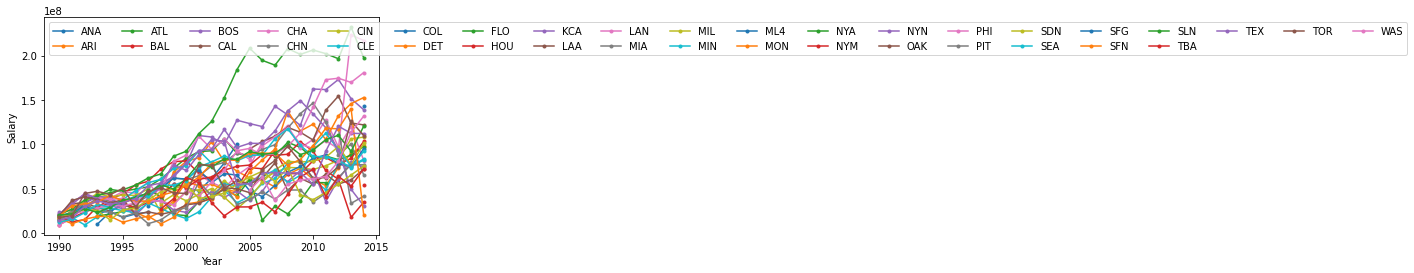

In [6]:
### Payroll Distribution

# Write code to produce plots that illustrate the distribution of payrolls across teams conditioned on time (from 1990-2014). 
# It will be a single plot with a line for each team. It is a plot between payroll on the y-axis and year (1990 - 2014) on the x-axis

prob2 = salary_info

groups = prob2.groupby('teamID')
for name, group in groups:
    plt.plot(group.yearID, group.total_salary, marker='o', linestyle='solid', markersize=3, label=name)
    
plt.xlabel("Year")
plt.ylabel("Salary")

plt.legend(ncol=20, loc='upper left')

# What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.

# From my observations I can tell that, most teams started to pay their players more as the years went on. 
# It also looks like one specific team (NYA) had a period of about 10 years where they were paying their players combined A LOT more than other teams
# In general all the teams tend to spend generally the same amount on their players, which makes sense because competition for good players is very high
# However, not much else can be said about the data since we cannot see how much they are paying for specific players and what the results are for paying their players more or less

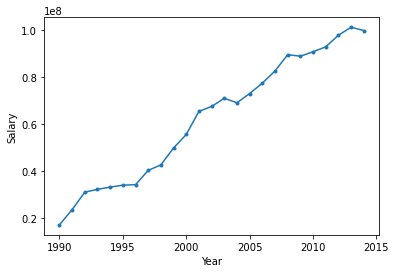

In [7]:

#My statement previously is that it seems that the average spent on salary for each team has increased over the last 25 years
# I created a graph that shows that overtime the mean payroll has increased.

plt.xlabel("Year")
plt.ylabel("Salary")

years=np.arange(1990,2015)
    
plt.plot(years, prob2.groupby('yearID')['total_salary'].mean(), marker='o', linestyle='solid', markersize=3, label=name)
plt.show()

R-squared: 0.165683


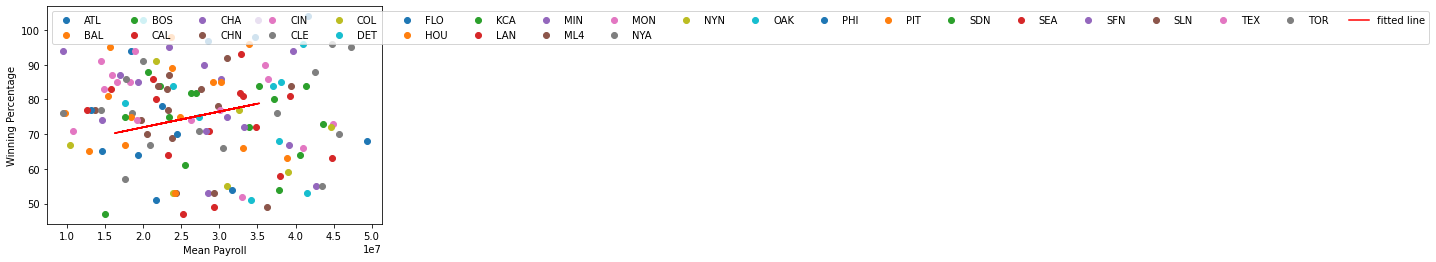

In [8]:
### Correlation between payroll and winning percentage

# Copied the merged data into this problem
prob4 = new_df

# Separate the by years 1990 - 1994, 1995 - 1999, 2000 - 2004, 2005 - 2009, 2010 - 2014)
pt1 = prob4[prob4['yearID'] < 1995]
pt2 = prob4[prob4['yearID'] < 2000]
pt2 = pt2[pt2['yearID'] >= 1995]
pt3 = prob4[prob4['yearID'] < 2005]
pt3 = pt3[pt3['yearID'] >= 2000]
pt4 = prob4[prob4['yearID'] < 2010]
pt4 = pt4[pt4['yearID'] >= 2005]
pt5 = prob4[prob4['yearID'] < 2015]
pt5 = pt5[pt5['yearID'] >= 2010]

# Make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. 
# Added a regression line in each scatter plot to ease interpretation.
# group by teams so each time has a legend
# group by teams and find the mean salary for each time within this time period
grouped = pt1.groupby('teamID')
mean1 = grouped.mean()

for name, group in grouped:
    plt.plot(group.total_salary, group.W, 'o', label=name)
    

plt.xlabel("Mean Payroll")
plt.ylabel("Winning Percentage")
# Adding regression line in the plot
res = stats.linregress(mean1['total_salary'], mean1['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
# plt.plot(mean1['total_salary'], mean1['W'], 'o', label='teamID')
plt.plot(mean1['total_salary'], res.intercept + res.slope*(mean1['total_salary']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

# Each plot is Mean Winning Percentage vs. Mean Payroll.

R-squared: 0.585418


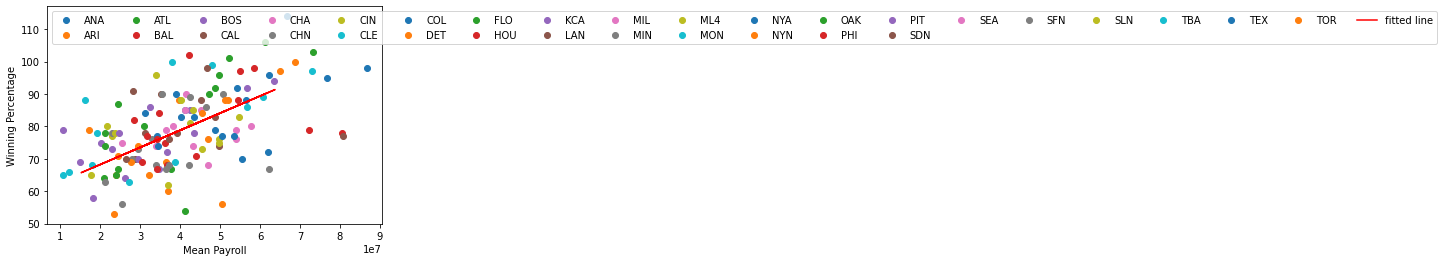

In [9]:
# Make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. 
# Added a regression line in each scatter plot to ease interpretation.

# grouped = pt2.groupby('yearID')
# mean2 = grouped.mean()

# the thing above does the exact same thing just a different way of implementing finding hte mean for each year
grouped = pt2.groupby('teamID')
mean2 = grouped.mean()

for name, group in grouped:
    plt.plot(group.total_salary, group.W, 'o', label=name)

plt.xlabel("Mean Payroll")
plt.ylabel("Winning Percentage")
# Adding regression line in the plot
res = stats.linregress(mean2['total_salary'], mean2['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
# plt.plot(mean2, w2, 'o', label=name)
plt.plot(mean2['total_salary'], res.intercept + res.slope*(mean2['total_salary']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

R-squared: 0.302215


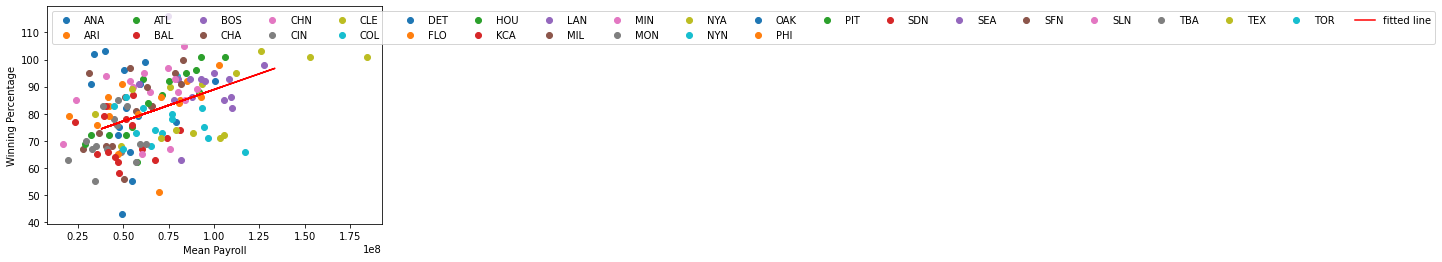

In [10]:
# Make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. 
# Added a regression line in each scatter plot to ease interpretation.

grouped = pt3.groupby('teamID')
mean3 = grouped.mean()

for name, group in grouped:
    plt.plot(group.total_salary, group.W, 'o', label=name)


# different way of grouping, i also did this when i was graphing the mean for each year (the mean for all the teams combined)
# mean3 = pt3.groupby('yearID')['total_salary'].mean())
# w3 = pt3.groupby('yearID')['W'].mean())


plt.xlabel("Mean Payroll")
plt.ylabel("Winning Percentage")
# Adding regression line in the plot
res = stats.linregress(mean3['total_salary'], mean3['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
# plt.plot(mean3['total_salary'], mean3['W'], 'o', label='original data')
plt.plot(mean3['total_salary'], res.intercept + res.slope*(mean3['total_salary']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

R-squared: 0.456591


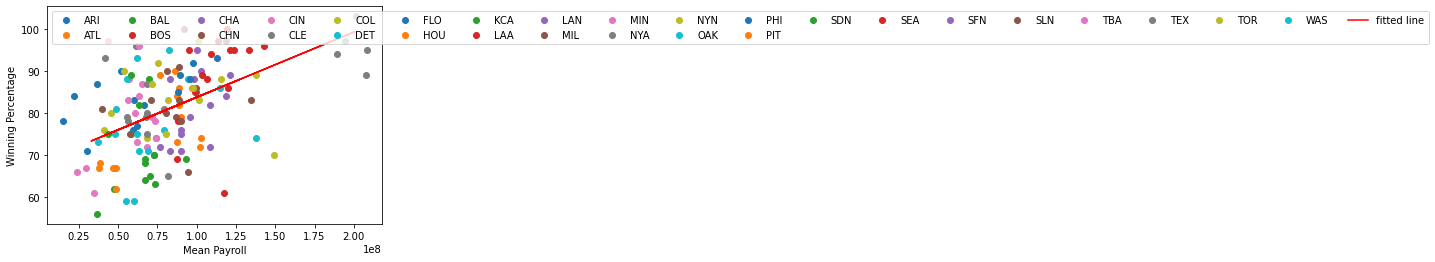

In [11]:
# Make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. 
# Added a regression line in each scatter plot to ease interpretation.
grouped = pt4.groupby('teamID')
mean4 = grouped.mean()

for name, group in grouped:
    plt.plot(group.total_salary, group.W, 'o', label=name)


plt.xlabel("Mean Payroll")
plt.ylabel("Winning Percentage")
# Adding regression line in the plot
res = stats.linregress(mean4['total_salary'], mean4['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
#plt.plot(mean4['total_salary'], mean4['W'], 'o', label='original data')
plt.plot(mean4['total_salary'], res.intercept + res.slope*(mean4['total_salary']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

R-squared: 0.171296


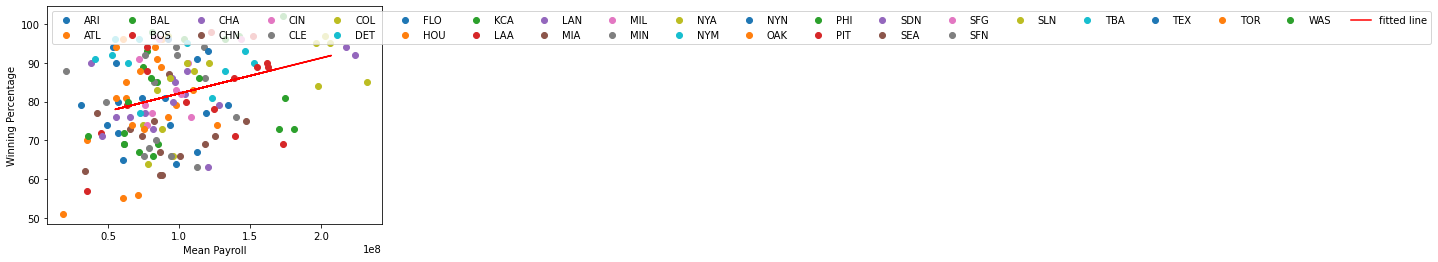

In [12]:
# Make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. 
# Added a regression line in each scatter plot to ease interpretation.
grouped = pt5.groupby('teamID')
mean5 = grouped.mean()

for name, group in grouped:
    plt.plot(group.total_salary, group.W, 'o', label=name)


plt.xlabel("Mean Payroll")
plt.ylabel("Winning Percentage")
# Adding regression line in the plot
res = stats.linregress(mean5['total_salary'], mean5['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
#plt.plot(mean5['total_salary'], mean5['W'], 'o', label='original data')
plt.plot(mean5['total_salary'], res.intercept + res.slope*(mean5['total_salary']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()



# What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? 
# What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

# It's really difficult to interpret anything from the 5 different plots we created that shows Mean Payroll vs. Winning Percentage
# You an tell that most of the teams started to pay their playeres (on average) about the same as other teams from Moneyball era and beyond
# Especially earlier within the data, it is clear that all of the teams had very different mean payrolls with different results in the winning percentage
# the fitted line from 2000 and beyond start off much higher than the ones from before 2000
# Regardless of the year the fitted line slope is positive which makes sense as mean payroll increases the winning percentage should
# also increase (otherwise your players are a waste of money!)
# it's really hard to figure out how OAK did during this period as there are a lot of data points and its really hard to figure out
# which one is specifically the one with teamID OAK. Even with the label its close to impossible since there are so many teams

## Part 3: Data Transformation

In [13]:
### Standardizing across years
# It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.


# Create a new variable in your dataset that standardizes payroll conditioned on year.
# Calculate the winning percentage
# team_info = team_info.assign(standardized_payroll = (salary_info.salary / salary_info.total_salary) / sj)

prob5 = new_df

# standard deviation of the year for salary
sj = prob5.groupby('yearID')['total_salary'].std()
# turn it into a numpy array
std_arr = np.array(sj)
# mean of the year for salary
mean5 = prob5.groupby('yearID')['total_salary'].mean()
# turn it into a numpy array
mean_arr = np.array(mean5)

groups = prob5.groupby('yearID')

prob5['standardized_pay'] = np.nan
prob5['standardized_pay'] = prob5['standardized_pay'].astype('float')

# go through every team combo for the year and create the standaridized pay for each team and year
for index, row in prob5.iterrows():

    i = row['yearID'] - 1990
    prob5.iloc[index, 7] =((prob5.iloc[index, 6] - mean_arr[i]) / std_arr[i])


print(prob5)
# So, this column for team i in year j should equal: standardized_payroll(ij) = (payroll(ij)-payroll(j))/s(j) for team i in year j 
# where avg_payrollj is the average payroll for year(j), and s(j) is the standard deviation of payroll for year j

        W      G franchID teamID  yearID  winning_percentage  total_salary  \
0    76.0  161.0      BAL    BAL    1990           47.204969     9680084.0   
1    88.0  162.0      BOS    BOS    1990           54.320988    20558333.0   
2    80.0  162.0      ANA    CAL    1990           49.382716    21720000.0   
3    94.0  162.0      CHW    CHA    1990           58.024691     9491500.0   
4    77.0  162.0      CLE    CLE    1990           47.530864    14487000.0   
..    ...    ...      ...    ...     ...                 ...           ...   
725  88.0  162.0      SFG    SFN    2014           54.320988    20000000.0   
726  90.0  162.0      STL    SLN    2014           55.555556   120693000.0   
727  96.0  162.0      WSN    WAS    2014           59.259259   131983680.0   
728  96.0  162.0      WSN    NYM    2014           59.259259    54806990.0   
729  96.0  162.0      WSN    SFG    2014           59.259259   143510167.0   

     standardized_pay  
0           -1.959861  
1            0.

R-squared: 0.188435


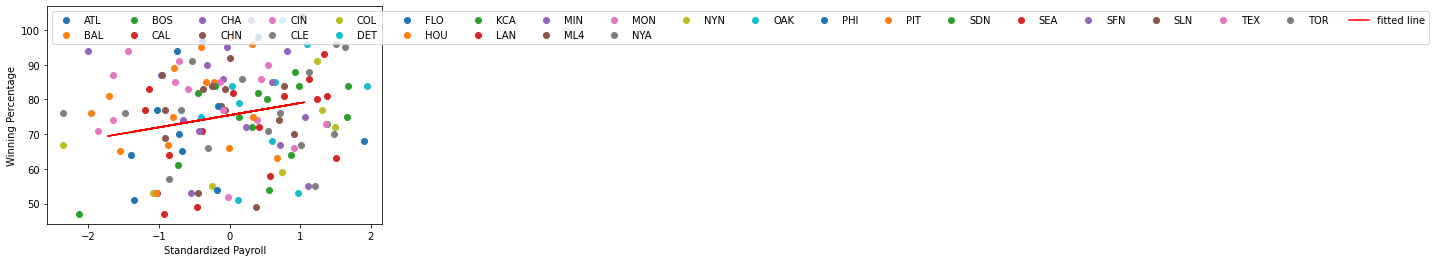

In [14]:

# Repeat the same plots as above, but use new standardized payroll variable.

# Copied the merged data into this problem
prob6 = prob5

# Separate the by years 1990 - 1994, 1995 - 1999, 2000 - 2004, 2005 - 2009, 2010 - 2014)
pt1 = prob6[prob6['yearID'] < 1995]
pt2 = prob6[prob6['yearID'] < 2000]
pt2 = pt2[pt2['yearID'] >= 1995]
pt3 = prob4[prob4['yearID'] < 2005]
pt3 = pt3[pt3['yearID'] >= 2000]
pt4 = prob4[prob4['yearID'] < 2010]
pt4 = pt4[pt4['yearID'] >= 2005]
pt5 = prob4[prob4['yearID'] < 2015]
pt5 = pt5[pt5['yearID'] >= 2010]

# Make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. 
# Added a regression line in each scatter plot to ease interpretation.


# Years 1990 - 1994
grouped = pt1.groupby('teamID')
mean1 = grouped.mean()

for name, group in grouped:
    plt.plot(group.standardized_pay, group.W, 'o', label=name)
    
plt.xlabel("Standardized Payroll")
plt.ylabel("Winning Percentage")


# Adding regression line in the plot
res = stats.linregress(mean1['standardized_pay'], mean1['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(mean1['standardized_pay'], res.intercept + res.slope*(mean1['standardized_pay']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

R-squared: 0.580810


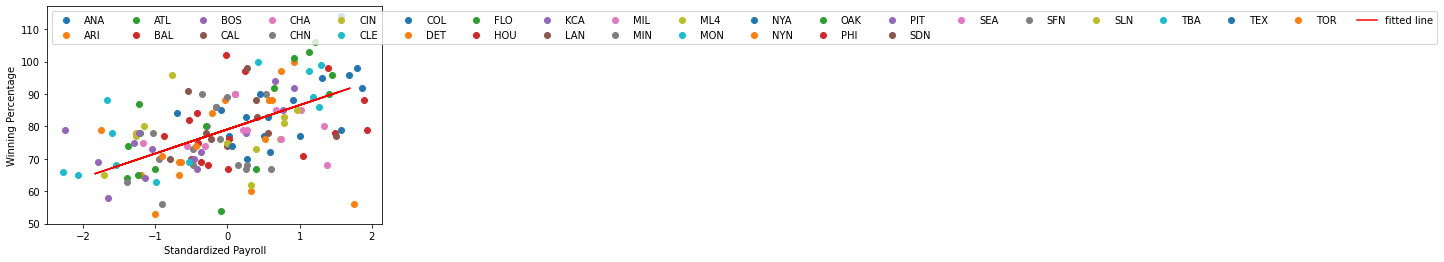

In [15]:
# The thing above does the exact same thing just a different way of implementing finding hte mean for each year

## Years 1995 - 1999
grouped = pt2.groupby('teamID')
mean2 = grouped.mean()

for name, group in grouped:
    plt.plot(group.standardized_pay, group.W, 'o', label=name)

plt.xlabel("Standardized Payroll")
plt.ylabel("Winning Percentage")
# Adding regression line in the plot
res = stats.linregress(mean2['standardized_pay'], mean2['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(mean2['standardized_pay'], res.intercept + res.slope*(mean2['standardized_pay']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

R-squared: 0.276183


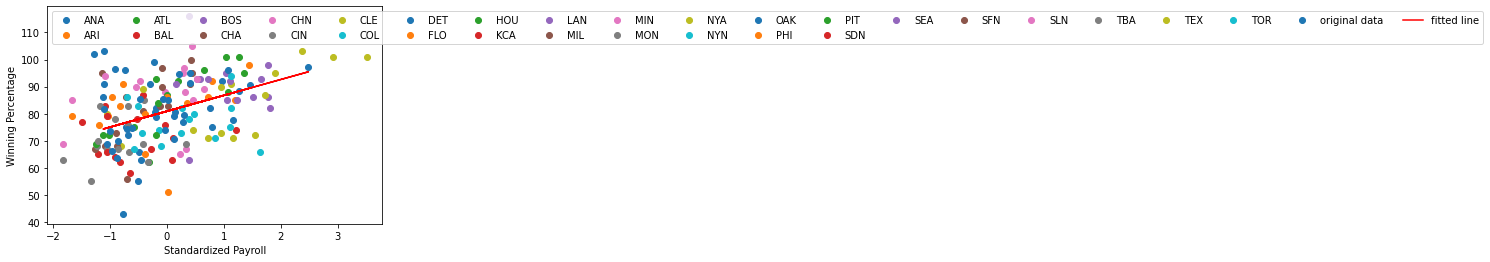

In [16]:
# The thing above does the exact same thing just a different way of implementing finding hte mean for each year

# Years 2000 - 2004
grouped = pt3.groupby('teamID')
mean3 = grouped.mean()

for name, group in grouped:
    plt.plot(group.standardized_pay, group.W, 'o', label=name)

plt.xlabel("Standardized Payroll")
plt.ylabel("Winning Percentage")
# Adding regression line in the plot
res = stats.linregress(mean3['standardized_pay'], mean3['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(mean3['standardized_pay'], mean3['W'], 'o', label='original data')
plt.plot(mean3['standardized_pay'], res.intercept + res.slope*(mean3['standardized_pay']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

R-squared: 0.456060


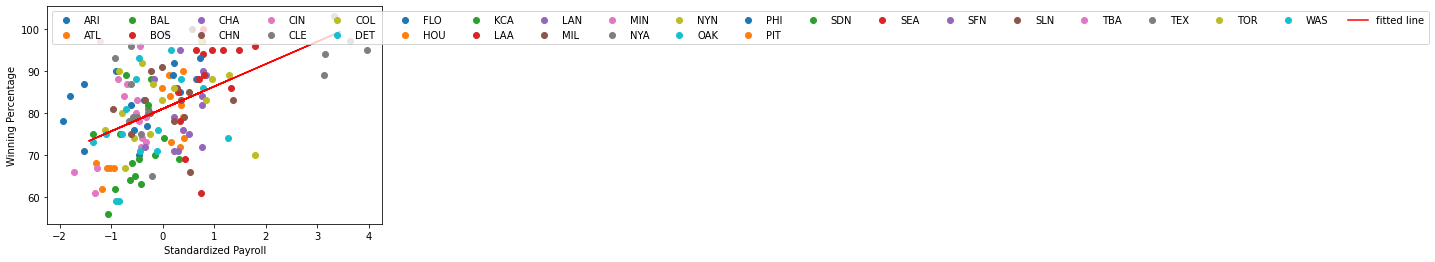

In [17]:
# The thing above does the exact same thing just a different way of implementing finding the mean for grouped years

# Years 2005 - 2009
grouped = pt4.groupby('teamID')
mean4 = grouped.mean()

plt.xlabel("Standardized Payroll")
plt.ylabel("Winning Percentage")
for name, group in grouped:
    plt.plot(group.standardized_pay, group.W, 'o', label=name)
    
# Adding regression line in the plot
res = stats.linregress(mean4['standardized_pay'], mean4['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(mean4['standardized_pay'], res.intercept + res.slope*(mean4['standardized_pay']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

R-squared: 0.153878


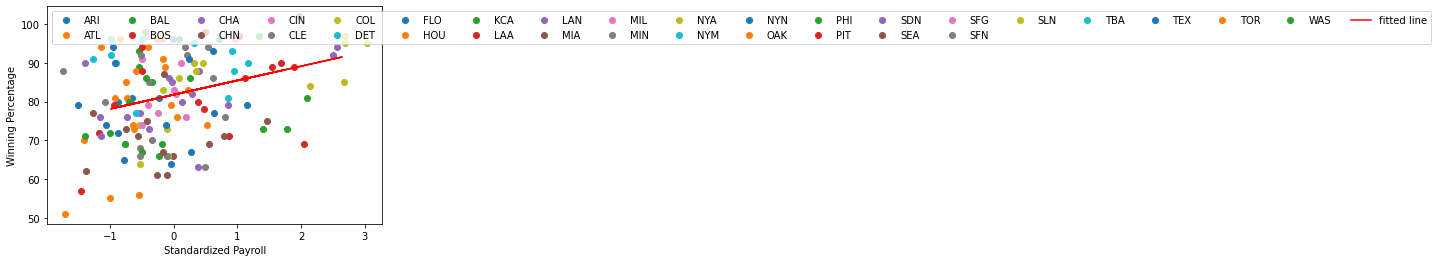

In [18]:
# The thing above does the exact same thing just a different way of implementing finding hte mean for each year

# Years 2010 - 2014)
grouped = pt5.groupby('teamID')
mean5 = grouped.mean()

plt.xlabel("Standardized Payroll")
plt.ylabel("Winning Percentage")

for name, group in grouped:
    plt.plot(group.standardized_pay, group.W, 'o', label=name)


# Adding regression line in the plot
res = stats.linregress(mean5['standardized_pay'], mean5['W'])
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(mean5['standardized_pay'], res.intercept + res.slope*(mean5['standardized_pay']), 'r', label='fitted line')
plt.legend(ncol=20, loc='upper left')
plt.show()

# Each plot is Mean Winning Percentage vs. Mean Payroll.

# Discuss how the plots from above reflect the transformation you did on the payroll variable.
# By showing a more scaled version of the mean payroll it is much easier to see who is over and under spending. 
# Looking at these graphs, it's very clear that the before the time period of 2000-2005 (which is when Moneyball took place),
# alot of the data was more spread out and the fitted line was much flatter
# Teams's winning percentage and standardized payroll are much closer together and the fitted line slope is much steeper after the Moneyball era. 
# It's clear that after 2000 the data more heavily lies closer to the standarized 0 or negatives rather than being equally spread out around 0 previous to
# 2000-2005 graph. Using this information will be very helpful as it has standarized the data and made it much more easier to compare with other data in the set now

R-squared: 0.147859


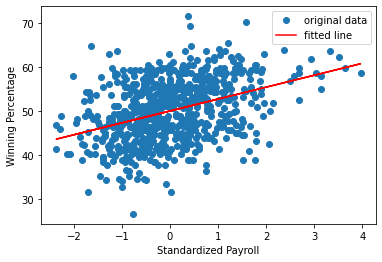

In [19]:
### Expected wins

# It's hard to see global trends across time periods using these multiple plots, but now that we have standardized payrolls across time, we can look at a single plot showing 
# correlation between winning percentage and payroll across time.


# Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship.

# The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the 
# average payroll in a given year will win 50% of their games (i.e. win\_pct is 50 when standardized\_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll 
# (i.e., win\_pct is 55 when standardized\_payroll is 2). We will see how this is done in general using linear regression later in the course.

prob7 = new_df

plt.xlabel("Standardized Payroll")
plt.ylabel("Winning Percentage")

# Adding regression line in the plot
res = stats.linregress(prob7['standardized_pay'], prob7['winning_percentage'])
print(f"R-squared: {res.rvalue**2:.6f}")
# insert all data points into this graph do not separate by time
plt.plot(prob7['standardized_pay'], prob7['winning_percentage'], 'o', label='original data')
plt.plot(prob7['standardized_pay'], res.intercept + res.slope*(prob7['standardized_pay']), 'r', label='fitted line')
plt.legend()
plt.show()

In [20]:
# From these observations we can calculate the expected win percentage for team i in year j as 
# expected_win_pctij = 50 + 2.5 x standardized_payroll ij

prob7['expected_win_pct'] = np.nan
prob7['expected_win_pct'] = prob7['expected_win_pct'].astype('float')

# expected_win_pctij = 50 + 2.5 x standardized_payroll ij
# compute coefficien

prob7 = prob7.assign(expected_win_pct = 50 + (2.5 * prob7.standardized_pay))

print(prob7.head())

      W      G franchID teamID  yearID  winning_percentage  total_salary  \
0  76.0  161.0      BAL    BAL    1990           47.204969     9680084.0   
1  88.0  162.0      BOS    BOS    1990           54.320988    20558333.0   
2  80.0  162.0      ANA    CAL    1990           49.382716    21720000.0   
3  94.0  162.0      CHW    CHA    1990           58.024691     9491500.0   
4  77.0  162.0      CLE    CLE    1990           47.530864    14487000.0   

   standardized_pay  expected_win_pct  
0         -1.959861         45.100348  
1          0.924213         52.310533  
2          1.232198         53.080495  
3         -2.009859         44.975353  
4         -0.685437         48.286408  


In [21]:
### Spending efficiency

# Create a new field to compute each team's spending effiency given by
# efficiency(ij) = win_pct(ij) - expected_win_pct(ij)
# for team i in year j, where expected_win_pct(ij) is given above

prob8 = prob7

# create the efficiency column
prob8['efficiency'] = np.nan
prob8['efficiency'] = prob8['efficiency'].astype('float')

# calculate efficiency
# efficiency(ij) = win_pct(ij) - expected_win_pct(ij)
prob8 = prob8.assign(efficiency = prob8['W'] - prob8['expected_win_pct'])

print(prob8.head())

      W      G franchID teamID  yearID  winning_percentage  total_salary  \
0  76.0  161.0      BAL    BAL    1990           47.204969     9680084.0   
1  88.0  162.0      BOS    BOS    1990           54.320988    20558333.0   
2  80.0  162.0      ANA    CAL    1990           49.382716    21720000.0   
3  94.0  162.0      CHW    CHA    1990           58.024691     9491500.0   
4  77.0  162.0      CLE    CLE    1990           47.530864    14487000.0   

   standardized_pay  expected_win_pct  efficiency  
0         -1.959861         45.100348   30.899652  
1          0.924213         52.310533   35.689467  
2          1.232198         53.080495   26.919505  
3         -2.009859         44.975353   49.024647  
4         -0.685437         48.286408   28.713592  


In [22]:
# Make a line plot with year on the x-axis and efficiency on the y-axis. A good set of teams to plot are Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay 
# (teamIDs OAK, BOS, NYA, ATL, TBA).

# find all of the good teams to plot 
oak = prob8.loc[prob8['teamID'] == 'OAK']
bos = prob8.loc[prob8['teamID'] == 'BOS']
nya = prob8.loc[prob8['teamID'] == 'NYA']
atl = prob8.loc[prob8['teamID'] == 'ATL']
tba = prob8.loc[prob8['teamID'] == 'TBA']

# add them to plot_data
plot_data = oak.append(bos).append(nya).append(atl).append(tba)

R-squared: 0.035592


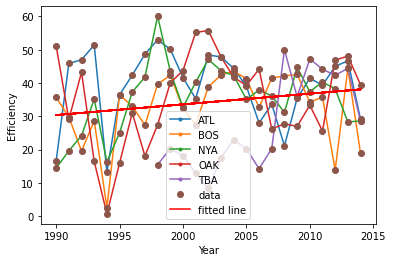

In [23]:
# plot the data
groups = plot_data.groupby('teamID')
for name, group in groups:
    plt.plot(group.yearID, group.efficiency, marker='o', linestyle='solid', markersize=3, label=name)

# label onto the plot
plt.xlabel("Year")
plt.ylabel("Efficiency")

# Adding regression line in the plot
res = stats.linregress(plot_data['yearID'], plot_data['efficiency'])
print(f"R-squared: {res.rvalue**2:.6f}")
plt.plot(plot_data['yearID'], plot_data['efficiency'], 'o', label='data')
plt.plot(plot_data['yearID'], res.intercept + res.slope*(plot_data['yearID']), 'r', label='fitted line')
plt.legend()
plt.show()


# What can you learn from this plot. How good was Oakland's efficiency during the Moneyball period?

# You can only really look at the data and try to figure out from looking at plots representing different time periods
# to then analyze how well teams spent their money over time
# by only using the eye to make these analysis, we lose a lot of important data and interpretation
# This graph is great as it doesn't overcrowd us with info like the other graphs (those carried too many team names so it was hard to see
# This graph's efficiency has generally increased over time, however, there was no specific spike for all teams after 2002 which is when Moneyball took
# place. It is clear that OAK (which is the team that Moneyball is based on) increased a lot around that time, however, it soon went down after 
# two years. This is most likely because other teams caught on to what they were doing. You can see a lot more specifics in how well the teams did
# rather than just looking at their salary or just looking at wins. This brings the two together and it becomes much easier to compare the different
# teams. During Moneyball though their effieincy spiked up to the highest during that time. It was not the most efficient anybody has ever been
# but it is close